# COVID19-related literature SQL database

In this notebook, we create a relational database dump of a set of COVID19-related publication datasets. These include:

* CORD19: https://pages.semanticscholar.org/coronavirus-research
* Dimensions: https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
* WHO: https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov

In [185]:
# magics, warnings and imports

%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import Integer,String,Boolean,DateTime

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load datasets

In [186]:
# point here to the versions of the datasets you want to use
dimensions_filename = "datasets_input/Dimensions_12_05_2020.csv"
who_filename = "datasets_input/WHO_12_05_2020.csv"
cord19_folder = "datasets_input/CORD19_2020_05_12"

df_dimensions = pd.read_csv(dimensions_filename, dtype=str)
df_who = pd.read_csv(who_filename, dtype=str)
df_cord = pd.read_csv(os.path.join(cord19_folder,"metadata.csv"), dtype=str)

In [187]:
df_cord.shape

(63571, 18)

### Prepare dataframes for ingestion

#### Clean-up data frames

##### Dimensions

In [188]:
df_dimensions.head()

,Date added,Publication ID,DOI,PMID,PMCID,Title,Abstract,Source title,Source UID,Publisher,...,Research Organizations - standardized,GRID IDs,City of Research organization,Country of Research organization,Funder,UIDs of supporting grants,Times cited,Altmetric,Source Linkout,Dimensions URL
0,2020-05-09,pub.1127445222,10.4088/pcc.20com02646,NaN,NaN,Reinventing Behavioral Health During the COVID...,NaN,The Primary Care Companion For CNS Disorders,jour.1021025,"Physicians Postgraduate Press, Inc",...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,https://app.dimensions.ai/details/publication/...
1,2020-05-09,pub.1127446583,10.7748/ncyp.32.3.7.s5,NaN,NaN,New picture book informs children about COVID-19,NaN,Nursing Children and Young People,jour.1044789,RCN Publishing,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,https://app.dimensions.ai/details/publication/...
2,2020-05-09,pub.1127439752,10.2196/preprints.19872,NaN,NaN,Severity Model Based Prediction of Early Trend...,"<sec xmlns=""http://www.ncbi.nlm.nih.gov/JATS1""...",JMIR Preprints,jour.1345647,JMIR Publications,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,http://dx.doi.org/10.2196/preprints.19872,https://app.dimensions.ai/details/publication/...
3,2020-05-09,pub.1127428552,10.1016/j.ptdy.2020.04.002,NaN,NaN,From uncertainty to empowerment: Pharmacists r...,NaN,Pharmacy Today,jour.1380594,Elsevier,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,https://app.dimensions.ai/details/publication/...
4,2020-05-09,pub.1127443624,10.35940/ijitee.f4642.049620,NaN,NaN,Fuzzy Logic Inference System for Identificatio...,Now a days Novel Coronavirus named COVID-19 be...,International Journal of Innovative Technology...,jour.1377485,Blue Eyes Intelligence Engineering and Science...,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,https://doi.org/10.35940/ijitee.f4642.049620,https://app.dimensions.ai/details/publication/...


In [189]:
df_dimensions.columns

Index(['Date added', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Abstract', 'Source title', 'Source UID', 'Publisher', 'MeSH terms',
       'Publication Date', 'PubYear', 'Volume', 'Issue', 'Pagination',
       'Open Access', 'Publication Type', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout', 'Dimensions URL'],
      dtype='object')

In [190]:
df_dimensions.drop(columns=['Date added', 'Publisher', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout'], inplace=True)

In [191]:
df_dimensions.columns

Index(['Publication ID', 'DOI', 'PMID', 'PMCID', 'Title', 'Abstract',
       'Source title', 'Source UID', 'MeSH terms', 'Publication Date',
       'PubYear', 'Volume', 'Issue', 'Pagination', 'Open Access',
       'Publication Type', 'Dimensions URL'],
      dtype='object')

In [192]:
df_dimensions.rename(columns={'Publication ID':'dimensions_id', 'DOI':'doi', 'PMID':'pmid', 'PMCID':'pmcid', 'Title':'title', 'Abstract':'abstract',
       'Source title':'journal', 'Source UID':'source_uid', 'MeSH terms':'mesh_terms', 'Publication Date':'publication_date',
       'PubYear':'publication_year', 'Volume':'volume', 'Issue':'issue', 'Pagination':'pages', 'Open Access':'open_access',
       'Publication Type':'publication_type', 'Dimensions URL':'dimensions_url'}, inplace=True)

In [193]:
def get_year(date):
    if isinstance(date,str) and len(date)>3 and date[:4].isdigit():
        return date[:4]
    return ""

month_to_number = {"Jan":"1","Feb":"2","Mar":"3","Apr":"4","May":"5","Jun":"6","Jul":"7","Aug":"8","Sep":"9","Oct":"10","Nov":"11","Dec":"12"}

def get_month(date):
    if isinstance(date,str) and len(date)>6:
        if "-" in date and date.split("-")[1].isdigit():
            return str(int(date.split("-")[1]))
        else:
            try:
                return month_to_number[date.split()[1]]
            except:
                return ""
    return ""

def sanitize_string(s):
    return " ".join(s.split())

In [194]:
df_dimensions["publication_year"] = df_dimensions["publication_year"].apply(get_year)
df_dimensions["publication_month"] = df_dimensions["publication_date"].apply(get_month)
df_dimensions["arxiv_id"] = ""

In [195]:
df_dimensions.drop(columns="publication_date", inplace=True)
df_dimensions = df_dimensions.fillna('')

In [196]:
# retrieve arXiv ID for Dimensions papers
# Sync option, quite slow

"""
import requests, re

for index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():
    r = requests.get(row["dimensions_url"])
    if r.status_code == 200:
        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()
        arxiv_id = arxiv_url.split(":")[-1]
        row["arxiv_id"] = arxiv_id
"""

'\nimport requests, re\n\nfor index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():\n    r = requests.get(row["dimensions_url"])\n    if r.status_code == 200:\n        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()\n        arxiv_id = arxiv_url.split(":")[-1]\n        row["arxiv_id"] = arxiv_id\n'

In [198]:
# from https://towardsdatascience.com/fast-and-async-in-python-accelerate-your-requests-using-asyncio-62dafca83c33
# aSync option, fast

import aiohttp
import requests
import asyncio

from aiohttp import ClientSession

def extract_fields_from_response(response):
    """Extract arxiv id from API's response"""
    search_res = re.search("arXiv:[0-9]+.[0-9]+",response)
    if search_res:
        arxiv_url = search_res.group()
        arxiv_id = arxiv_url.split(":")[-1]
        return arxiv_id
    return ""

async def get_details_async(session, payload):   
    response = await session.request(method='GET', url=payload[1]["dimensions_url"])
    if response.status != 200:
        print(payload[0], response.status)
        pass
    return await response.text()

async def run_program(session, payload):
    """Wrapper for running program in an asynchronous manner"""
    response = await get_details_async(session, payload)
    arxiv_id = extract_fields_from_response(response)
    return (arxiv_id,payload[1]["dimensions_url"])

payloads = df_dimensions[df_dimensions.journal=="arXiv"]
connector = aiohttp.TCPConnector(limit=5)
async with aiohttp.ClientSession(connector=connector) as session:
    results = await asyncio.gather(*[run_program(session, payload) for payload in payloads.iterrows()])

In [199]:
df_tmp = pd.DataFrame.from_dict({"arxiv_id":[x[0] for x in results],"dimensions_url":[x[1] for x in results]})

In [200]:
df_tmp.shape

(783, 2)

In [201]:
df_dimensions = df_dimensions.merge(df_tmp, how="left", left_on="dimensions_url", right_on="dimensions_url")
df_dimensions.drop(columns="arxiv_id_x", inplace=True)
df_dimensions.rename(columns={"arxiv_id_y":"arxiv_id"}, inplace=True)
df_dimensions = df_dimensions.fillna('')

In [204]:
df_dimensions.shape

(27885, 18)

In [205]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(783, 18)

In [206]:
df_dimensions.head()

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
0,pub.1127445222,10.4088/pcc.20com02646,,,Reinventing Behavioral Health During the COVID...,,The Primary Care Companion For CNS Disorders,jour.1021025,,2020,22,3,,Closed,article,https://app.dimensions.ai/details/publication/...,5,
1,pub.1127446583,10.7748/ncyp.32.3.7.s5,,,New picture book informs children about COVID-19,,Nursing Children and Young People,jour.1044789,,2020,32,3,7-7,Closed,article,https://app.dimensions.ai/details/publication/...,5,
2,pub.1127439752,10.2196/preprints.19872,,,Severity Model Based Prediction of Early Trend...,"<sec xmlns=""http://www.ncbi.nlm.nih.gov/JATS1""...",JMIR Preprints,jour.1345647,,2020,,,,"All OA; Green, Submitted",preprint,https://app.dimensions.ai/details/publication/...,5,
3,pub.1127428552,10.1016/j.ptdy.2020.04.002,,,From uncertainty to empowerment: Pharmacists r...,,Pharmacy Today,jour.1380594,,2020,26,5,6,Closed,article,https://app.dimensions.ai/details/publication/...,5,
4,pub.1127443624,10.35940/ijitee.f4642.049620,,,Fuzzy Logic Inference System for Identificatio...,Now a days Novel Coronavirus named COVID-19 be...,International Journal of Innovative Technology...,jour.1377485,,2020,9,4,1575-1580,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,4,


In [207]:
df_dimensions[df_dimensions.doi==""].shape

(1054, 18)

##### WHO

In [208]:
df_who.head()

,Title,Authors,Abstract,Published Year,Published Month,Journal,Volume,Issue,Pages,Accession Number,DOI,Ref,Covidence #,Study,Notes,Tags,Cov Num
0,Recent advances in the detection of respirator...,"Zhang, N.; Wang, L.; Deng, X.; Liang, R.; Su, ...",Respiratory tract viral infection caused by vi...,2020,NaN,Journal of medical virology,NaN,NaN,NaN,31944312,10.1002/jmv.25674,6,#2,Zhang 2020,NaN,"* Narrative review; Clinical aspects, diagnosi...",2
1,"Pneumonia of Unknown Etiology in Wuhan, China:...","Bogoch, I. I.; Watts, A.; Thomas-Bachli, A.; H...",There is currently an outbreak of a pneumonia ...,2020,NaN,Journal of travel medicine,NaN,NaN,NaN,NaN,10.1093/jtm/taaa008,13,#4,Bogoch 2020,Jose Garnica (2020-01-29 23:40:16)(Included):...,* Case study/series; * Epidemiological study; ...,4
2,A Novel Coronavirus from Patients with Pneumon...,"Zhu, N.; Zhang, D.; Wang, W.; Li, X.; Yang, B....","In December 2019, a cluster of patients with p...",2020,NaN,The New England journal of medicine,NaN,NaN,NaN,31978945,10.1056/NEJMoa2001017,24,#8,Zhu 2020,NaN,NaN,8
3,A Novel Coronavirus Emerging in China - Key Qu...,"Munster, V. J.; Koopmans, M.; van Doremalen, N...",NaN,2020,NaN,The New England journal of medicine,NaN,NaN,NaN,31978293,10.1056/NEJMp2000929,25,#9,Munster 2020,NaN,NaN,9
4,Molecular mechanism for antibody-dependent enh...,"Wan, Y.; Shang, J.; Sun, S.; Tai, W.; Chen, J....",Antibody-dependent enhancement (ADE) of viral ...,2019,NaN,Journal of virology,NaN,NaN,NaN,NaN,10.1128/JVI.02015-19,15,#10,Wan 2019,NaN,"Other related diseases and viruses; Virology, ...",10


In [209]:
df_who.columns

Index(['Title', 'Authors', 'Abstract', 'Published Year', 'Published Month',
       'Journal', 'Volume', 'Issue', 'Pages', 'Accession Number', 'DOI', 'Ref',
       'Covidence #', 'Study', 'Notes', 'Tags', 'Cov Num'],
      dtype='object')

In [210]:
df_who.drop(columns="Authors", inplace=True)

In [211]:
df_who.rename(columns={'Title':'title', 'Abstract':'abstract', 'Published Year':'publication_year', 'Published Month':'publication_month',
       'Journal':'journal', 'Volume':'volume', 'Issue':'issue', 'Pages':'pages', 'Accession Number':'accession_number', 'DOI':'doi', 'Ref':'ref',
       'Covidence #':'covidence', 'Study':'study', 'Notes':'notes', 'Tags':'tags'}, inplace=True)

In [212]:
df_who["pmid"] = ""
df_who["pmcid"] = ""
df_who["dimensions_id"] = ""
df_who["arxiv_id"] = ""
df_who = df_who.fillna('')

In [213]:
df_who.head()

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,accession_number,doi,ref,covidence,study,notes,tags,Cov Num,pmid,pmcid,dimensions_id,arxiv_id
0,Recent advances in the detection of respirator...,Respiratory tract viral infection caused by vi...,2020,,Journal of medical virology,,,,31944312,10.1002/jmv.25674,6,#2,Zhang 2020,,"* Narrative review; Clinical aspects, diagnosi...",2,,,,
1,"Pneumonia of Unknown Etiology in Wuhan, China:...",There is currently an outbreak of a pneumonia ...,2020,,Journal of travel medicine,,,,,10.1093/jtm/taaa008,13,#4,Bogoch 2020,Jose Garnica (2020-01-29 23:40:16)(Included):...,* Case study/series; * Epidemiological study; ...,4,,,,
2,A Novel Coronavirus from Patients with Pneumon...,"In December 2019, a cluster of patients with p...",2020,,The New England journal of medicine,,,,31978945,10.1056/NEJMoa2001017,24,#8,Zhu 2020,,,8,,,,
3,A Novel Coronavirus Emerging in China - Key Qu...,,2020,,The New England journal of medicine,,,,31978293,10.1056/NEJMp2000929,25,#9,Munster 2020,,,9,,,,
4,Molecular mechanism for antibody-dependent enh...,Antibody-dependent enhancement (ADE) of viral ...,2019,,Journal of virology,,,,,10.1128/JVI.02015-19,15,#10,Wan 2019,,"Other related diseases and viruses; Virology, ...",10,,,,


In [214]:
df_who[df_who.doi==""].shape

(1624, 20)

##### CORD19

In [215]:
df_cord.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,green-oa,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/b2897e1277f56641193a6...,document_parses/pmc_json/PMC125340.xml.json,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,green-oa,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/e3d0d482ebd9a8ba81c25...,document_parses/pmc_json/PMC125375.xml.json,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,document_parses/pdf_json/00b1d99e70f779eb4ede5...,document_parses/pmc_json/PMC125543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,green-oa,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/cf584e00f637cbd8f1bb3...,document_parses/pmc_json/PMC126080.xml.json,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,green-oa,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/dde02f11923815e6a16a3...,document_parses/pmc_json/PMC136939.xml.json,http://europepmc.org/articles/pmc136939?pdf=re...


In [216]:
df_cord["license"].value_counts()

els-covid      19334
no-cc          15307
cc-by           9852
bronze-oa       4747
unk             3319
green-oa        2670
medrxiv         2391
cc-by-nc        1332
biorxiv         1122
arxiv           1121
cc-by-nc-nd      840
cc-by-nc-sa      499
gold-oa          403
hybrid-oa        359
cc0              266
cc-by-nd           5
cc-by-sa           2
pd                 2
Name: license, dtype: int64

In [217]:
df_cord["source_x"].value_counts()

PMC                          32802
Elsevier; PMC                16236
Elsevier                      8083
medrxiv                       2390
biorxiv                       1122
ArXiv                         1115
WHO                            898
PMC; WHO                       312
Elsevier; PMC; WHO             221
Elsevier; WHO                  175
CZI; PMC                        84
CZI; Elsevier; PMC              34
CZI                             33
ArXiv; PMC                      28
CZI; Elsevier                   15
ArXiv; Elsevier; PMC            13
ArXiv; Elsevier                  6
ArXiv; Elsevier; PMC; WHO        1
ArXiv; medrxiv                   1
ArXiv; WHO                       1
ArXiv; PMC; WHO                  1
Name: source_x, dtype: int64

In [218]:
# NEW columns (for now, we drop)
df_cord.drop(columns=["cord_uid","url","pdf_json_files","pmc_json_files"],inplace=True)

In [219]:
df_cord.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id'],
      dtype='object')

In [220]:
df_cord.drop(columns='authors', inplace=True)
df_cord = df_cord.fillna('')

In [221]:
df_cord.rename(columns={'source_x':'source', 'pubmed_id': 'pmid',
       'mag_id': 'ms_academic_id', 'who_covidence_id': 'who_covidence'}, inplace=True)

In [222]:
df_cord["publication_year"] = df_cord["publish_time"].apply(get_year)
df_cord["publication_month"] = df_cord["publish_time"].apply(get_month)

In [223]:
df_cord.drop(columns='publish_time', inplace=True)

In [224]:
df_cord['pages'] = ""
df_cord['volume'] = ""
df_cord['issue'] = ""
df_cord["dimensions_id"] = ""

In [225]:
df_cord.head()

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
0,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,green-oa,Nidovirus subgenomic mRNAs contain a leader se...,The EMBO Journal,,,,2001,12,,,,
1,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,green-oa,CEACAM1 is a member of the carcinoembryonic an...,The EMBO Journal,,,,2002,5,,,,
2,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,EMBO J,,,,2001,7,,,,
3,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,green-oa,The key enzyme in coronavirus polyprotein proc...,The EMBO Journal,,,,2002,7,,,,
4,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,green-oa,"Arteri-, corona-, toro- and roniviruses are ev...",The EMBO Journal,,,,2002,12,,,,


In [226]:
df_cord[(df_cord.doi=="") & ((df_cord.sha!="") | (df_cord.pmid!="") | (df_cord.pmcid!="") | df_cord.arxiv_id!="")].shape

(4409, 18)

In [227]:
df_cord[(df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid=="")].shape

(1359, 18)

In [228]:
df_cord[((df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid==""))&(df_cord.arxiv_id!="")].shape

(1053, 18)

In [229]:
df_dimensions.shape

(27885, 18)

In [230]:
df_who.shape

(16809, 20)

In [231]:
df_cord.shape

(63571, 18)

In [232]:
df_cord[df_cord.doi=="0.1126/science.abb7331"]

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
41736,,WHO,‘A ticking time bomb’: Scientists worry about ...,0.1126/science.abb7331,,,unk,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",Science,,#8463,,2020,,,,,


In [233]:
df_dimensions[((df_dimensions.doi=="") & (df_dimensions.pmid=="") & (df_dimensions.pmcid==""))&(df_dimensions.journal=="arXiv")].shape

(783, 18)

In [234]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(783, 18)

In [235]:
df_cord[df_cord.arxiv_id!=""].shape

(1166, 18)

In [236]:
df_cord[df_cord.title=="CORD-19: The Covid-19 Open Research Dataset"]

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
45343,bc411487f305e451d7485e53202ec241fcc97d3b,ArXiv,CORD-19: The Covid-19 Open Research Dataset,,,,arxiv,The Covid-19 Open Research Dataset (CORD-19) i...,,,,2004.10706,2020,4,,,,


In [237]:
df_dimensions[df_dimensions.title=="CORD-19: The Covid-19 Open Research Dataset"]

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
8531,pub.1126924428,,,,CORD-19: The Covid-19 Open Research Dataset,The Covid-19 Open Research Dataset (CORD-19) i...,arXiv,jour.1371339,,2020,,,,"All OA; Green, Submitted",preprint,https://app.dimensions.ai/details/publication/...,4,2004.10706


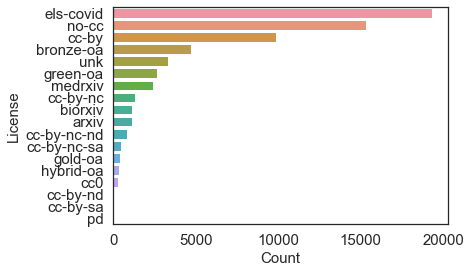

In [238]:
# license
df_sub = df_cord[df_cord.license.isin(df_cord.license.value_counts()[:30].index.tolist())]
b = sns.countplot(y="license", data=df_sub, order=df_sub['license'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("License",fontsize=15)
b.tick_params(labelsize=15)

### Prepare tables

In [301]:
# the main table: pub

In [302]:
pub_table_columns = ['title','abstract','publication_year','publication_month','journal','volume','issue','pages','doi','pmid','pmcid','dimensions_id','arxiv_id']

df_pub = df_dimensions[pub_table_columns].append(df_who[pub_table_columns], ignore_index = True)

In [303]:
df_pub = df_pub[pub_table_columns].append(df_cord[pub_table_columns], ignore_index=True)

In [304]:
df_pub["title"] = df_pub["title"].apply(sanitize_string)
df_pub["abstract"] = df_pub["abstract"].apply(sanitize_string)
df_pub["doi"] = df_pub["doi"].apply(str.lower)
df_pub["pmid"] = df_pub["pmid"].apply(str.lower)
df_pub["pmcid"] = df_pub["pmcid"].apply(str.lower)
df_pub["dimensions_id"] = df_pub["dimensions_id"].apply(str.lower)
df_pub["arxiv_id"] = df_pub["arxiv_id"].apply(str.lower)

In [305]:
df_pub.shape

(108265, 13)

In [306]:
df_pub[(df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id=="")].shape

(1930, 13)

In [307]:
# check to have at least one valid identifier per publication
# we drop publications which do not: hopefully, they will be equipped with an identifier in future releases

df_pub = df_pub[~((df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id==""))]

In [308]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id
29733,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,0.1126/science.abb7331,,,,
86430,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,0.1126/science.abb7331,,,,


In [309]:
# drop duplicates, first on dois then pmids then pmcids. We need this to keep empty values!
df_tmp = df_pub[df_pub.doi==""]
df_pub1 = df_pub[df_pub.doi!=""].groupby('doi').first()
df_pub1.reset_index(inplace=True)
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_pub2 = df_tmp[df_tmp.pmid!=""].groupby('pmid').first()
df_pub2.reset_index(inplace=True)
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_pub3 = df_tmp2[df_tmp2.pmcid!=""].groupby('pmcid').first()
df_pub3.reset_index(inplace=True)
df_tmp4 = df_tmp3[df_tmp3.arxiv_id==""]
df_pub4 = df_tmp3[df_tmp3.arxiv_id!=""].groupby('arxiv_id').first()
df_pub4.reset_index(inplace=True)
df_pub5 = df_tmp4[df_tmp4.dimensions_id!=""].groupby('dimensions_id').first()
df_pub5.reset_index(inplace=True)

In [310]:
df_pub1[df_pub1.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,,,,


In [311]:
df_pub = pd.concat([df_pub1,df_pub2,df_pub3,df_pub4,df_pub5])

In [312]:
# add PK and reset index
df_pub.reset_index(drop=True,inplace=True)
df_pub["pub_id"] = df_pub.index.values

In [313]:
df_pub.shape

(83363, 14)

In [314]:
df_pub[df_pub.arxiv_id=="2003.08720"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
82506,,Social distancing versus early detection and c...,Different countries -- and sometimes different...,2020,3,arXiv,,,,,,pub.1126058658,2003.08720,82506


In [315]:
# create other tables via joins

df_datasource = pd.DataFrame.from_dict({"source":["CORD19","Dimensions","WHO"],"url":["https://pages.semanticscholar.org/coronavirus-research","https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255",
"https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov"]})
df_cord_metadata = df_cord[['source','license','ms_academic_id','who_covidence','doi','pmid','pmcid','sha','arxiv_id']]
df_who_metadata = df_who[['accession_number', 'doi', 'ref',
       'covidence', 'study', 'notes', 'tags', 'pmid', 'pmcid']]
df_dimensions_metadata = df_dimensions[['dimensions_id', 'doi', 'pmid', 'pmcid','arxiv_id', 'source_uid', 'mesh_terms',
       'open_access', 'publication_type', 'dimensions_url']]

In [316]:
df_cord_metadata["doi"] = df_cord_metadata["doi"].apply(str.lower)
df_cord_metadata["pmid"] = df_cord_metadata["pmid"].apply(str.lower)
df_cord_metadata["pmcid"] = df_cord_metadata["pmcid"].apply(str.lower)
df_who_metadata["doi"] = df_who_metadata["doi"].apply(str.lower)
df_who_metadata["pmid"] = df_who_metadata["pmid"].apply(str.lower)
df_who_metadata["pmcid"] = df_who_metadata["pmcid"].apply(str.lower)
df_dimensions_metadata["doi"] = df_dimensions_metadata["doi"].apply(str.lower)
df_dimensions_metadata["pmid"] = df_dimensions_metadata["pmid"].apply(str.lower)
df_dimensions_metadata["pmcid"] = df_dimensions_metadata["pmcid"].apply(str.lower)

In [317]:
df_datasource.head()

,source,url
0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...
2,WHO,https://www.who.int/emergencies/diseases/novel...


In [318]:
# CORD19 metadata

In [319]:
df_cord_metadata.shape

(63571, 9)

In [320]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020,,Science,,,,,,,,0


In [321]:
#We need this to keep empty values!

df_tmp = df_cord_metadata[df_cord_metadata.doi==""]
df_cord_metadata1 = pd.merge(df_cord_metadata[df_cord_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_cord_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_cord_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])
df_cord_metadata4 = pd.merge(df_tmp3[df_tmp3.arxiv_id!=""], df_pub[['pub_id','arxiv_id']],  how='inner', left_on=['arxiv_id'], right_on=['arxiv_id'])

In [322]:
df_cord_metadata1 = df_cord_metadata1.groupby("doi").first()
df_cord_metadata1.reset_index(inplace=True)
df_cord_metadata2 = df_cord_metadata2.groupby("pmid").first()
df_cord_metadata2.reset_index(inplace=True)
df_cord_metadata3 = df_cord_metadata3.groupby("pmcid").first()
df_cord_metadata3.reset_index(inplace=True)
df_cord_metadata4 = df_cord_metadata4.groupby("arxiv_id").first()
df_cord_metadata4.reset_index(inplace=True)

In [323]:
df_cord_metadata = pd.concat([df_cord_metadata1,df_cord_metadata2,df_cord_metadata3,df_cord_metadata4])

In [324]:
df_cord_metadata.shape

(63238, 10)

In [261]:
# read full texts in
folders = ['document_parses/pdf_json']
shas = list()
full_texts = list()

for folder in folders:
    for root, dirs, files in os.walk(os.path.join(cord19_folder,folder)):
        for file in tqdm(files):
            if ".json" in file: # read
                data = json.loads(codecs.open(os.path.join(root,file)).read())
                sha = data["paper_id"]
                full_text = " ".join(sanitize_string(section["text"]) for section in data["body_text"])
                shas.append(sha)
                full_texts.append(full_text)

In [325]:
df_cord_fulltext = pd.DataFrame.from_dict({"sha":shas,"full_text":full_texts})

In [326]:
df_cord_fulltext.shape

(51868, 2)

In [327]:
df_cord_metadata = pd.merge(df_cord_metadata, df_cord_fulltext,  how='left', left_on=['sha'], right_on=['sha'])
df_cord_metadata = df_cord_metadata.fillna('')
df_cord_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [328]:
df_cord_metadata.head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
0,0.1126/science.abb7331,WHO,unk,,#8463,,,,,0,
1,10.0376/cma.j.issn.0376-2491.2020.0002,WHO,unk,3003451419,#615,32036640,,,,1,
2,10.1001/archinte.168.22.2489,PMC,bronze-oa,,,19064834,pmc2783624,,,3,
3,10.1001/jama.2010.675,PMC,bronze-oa,,,20501927,pmc2968755,,,4,
4,10.1001/jama.2014.2116,PMC,green-oa,,,24566924,pmc6689404,,,5,


In [329]:
df_cord_metadata[df_cord_metadata.arxiv_id!=""].head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
4927,10.1007/s10494-011-9345-0,ArXiv,arxiv,,,,,,1305.2885,6736,
5091,10.1007/s10955-013-0690-3,ArXiv,arxiv,,,,,67326b132f0b8258c4cd41a517b2d65404d58901,1211.2163,6954,that the population within a single subpopulat...
5092,10.1007/s10955-014-1024-9,ArXiv; PMC,no-cc,,,26074625,pmc4457089,535448073c1721a7928c2814283c5cda6e151902; 2305...,1402.7011,6955,
5198,10.1007/s11232-014-0210-x,ArXiv,arxiv,,,,,8abce2326a7c9a4f589e3bfe3480b766f7fd5d5e,1406.7468,7093,Ludvig Faddeev is the first to draw my attenti...
5492,10.1007/s11433-013-5321-0,ArXiv; PMC,arxiv,,,,pmc7111546,7efbb19025f7bb3da296980c50e4e0edc4a340b3; c742...,1304.5603,7431,


In [330]:
# WHO and Dimensions metadata

In [331]:
df_tmp = df_who_metadata[df_who_metadata.doi==""]
df_who_metadata1 = pd.merge(df_who_metadata[df_who_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_who_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_who_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])

In [332]:
df_who_metadata1 = df_who_metadata1.groupby("doi").first()
df_who_metadata1.reset_index(inplace=True)
df_who_metadata2 = df_who_metadata2.groupby("pmid").first()
df_who_metadata2.reset_index(inplace=True)
df_who_metadata3 = df_who_metadata3.groupby("pmcid").first()
df_who_metadata3.reset_index(inplace=True)

In [333]:
df_who_metadata = pd.concat([df_who_metadata1,df_who_metadata2,df_who_metadata3])

In [334]:
df_who_metadata.shape

(14373, 10)

In [335]:
df_who_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [336]:
df_tmp = df_dimensions_metadata[df_dimensions_metadata.dimensions_id==""]
df_dimensions_metadata1 = pd.merge(df_dimensions_metadata[df_dimensions_metadata.dimensions_id!=""], df_pub[['pub_id','dimensions_id']],  how='inner', left_on=['dimensions_id'], right_on=['dimensions_id'])

In [337]:
df_dimensions_metadata1 = df_dimensions_metadata1.groupby("dimensions_id").first()
df_dimensions_metadata1.reset_index(inplace=True)

In [338]:
df_dimensions_metadata = pd.concat([df_dimensions_metadata1])

In [339]:
df_dimensions_metadata.shape

(27770, 11)

In [340]:
df_dimensions_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [341]:
# Create datasource tables

In [342]:
cord_source_id = df_datasource[df_datasource.source=="CORD19"].index.values[0]
who_source_id = df_datasource[df_datasource.source=="WHO"].index.values[0]
dimensions_source_id = df_datasource[df_datasource.source=="Dimensions"].index.values[0]

In [343]:
df_cord_metadata["source_id"] = cord_source_id
df_who_metadata["source_id"] = who_source_id
df_dimensions_metadata["source_id"] = dimensions_source_id

In [344]:
df_pub_to_datasource = df_cord_metadata[["pub_id","source_id"]]
df_pub_to_datasource = df_pub_to_datasource.append(df_who_metadata[["pub_id","source_id"]],ignore_index=True)
df_pub_to_datasource = df_pub_to_datasource.append(df_dimensions_metadata[["pub_id","source_id"]],ignore_index=True)

In [345]:
df_pub_to_datasource.drop_duplicates(inplace=True)
df_pub_to_datasource.rename(columns={"source_id":"datasource_id"},inplace=True)

In [346]:
df_pub_to_datasource.shape

(105363, 2)

In [347]:
df_pub_to_datasource[df_pub_to_datasource.pub_id==22787]

,pub_id,datasource_id
20089,22787,0


In [348]:
# remove unnecessary columns
df_cord_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)
df_who_metadata.drop(columns=['doi','pmid','pmcid','source_id'],inplace=True)
df_dimensions_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)

In [349]:
# reset all indexes which will become PKs
df_cord_metadata.reset_index(drop=True,inplace=True)
df_who_metadata.reset_index(drop=True,inplace=True)
df_dimensions_metadata.reset_index(drop=True,inplace=True)
df_datasource.reset_index(drop=True,inplace=True)
df_cord_metadata["cord19_metadata_id"] = df_cord_metadata.index.values
df_who_metadata["who_metadata_id"] = df_who_metadata.index.values
df_dimensions_metadata["dimensions_metadata_id"] = df_dimensions_metadata.index.values
df_datasource["datasource_metadata_id"] = df_datasource.index.values

In [350]:
# make numeric where needed
df_pub["publication_year"] = pd.to_numeric(df_pub["publication_year"])
df_pub["publication_month"] = pd.to_numeric(df_pub["publication_month"])
df_pub["pmid"] = pd.to_numeric(df_pub["pmid"])

In [351]:
# add timestamp
df_pub["timestamp"] = pd.Timestamp.now()

In [352]:
# clean-up text (optional)
replaces = [""]

def clean_up(txt):
    for r in replaces:
        txt = txt.replace(r,"")
    return txt.encode('utf8', 'ignore').decode('utf8')
df_pub["abstract"] = [clean_up(a) for a in df_pub["abstract"].values]

In [353]:
df_pub.head()

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id,timestamp
0,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,,,,NaN,,,,0,2020-05-14 17:36:03.858343
1,10.0376/cma.j.issn.0376-2491.2020.0002,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,32036640.0,,pub.1124777091,,1,2020-05-14 17:36:03.858343
2,10.1001/amajethics.2020.344,Cohesion in Distancing.,"In isolation, we are physically apart; in soli...",2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,32345430.0,,pub.1127182341,,2,2020-05-14 17:36:03.858343
3,10.1001/archinte.168.22.2489,Another Piece of the Puzzle: Human Metapneumov...,BACKGROUND: Each winter respiratory viruses ac...,2008.0,12.0,Archives of Internal Medicine,,,,19064834.0,pmc2783624,,,3,2020-05-14 17:36:03.858343
4,10.1001/jama.2010.675,Viral etiology of severe pneumonia among Kenya...,CONTEXT: Pneumonia is the leading cause of chi...,2010.0,5.0,JAMA,,,,20501927.0,pmc2968755,,,4,2020-05-14 17:36:03.858343


In [354]:
# reorder the columns to match the SQL schema

df_datasource.columns

Index(['source', 'url', 'datasource_metadata_id'], dtype='object')

In [355]:
df_pub = df_pub[['pub_id', 'title', 'abstract', 'publication_year', 'publication_month', 'journal',
       'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid', 'dimensions_id', 'arxiv_id',
       'timestamp']]
df_who_metadata = df_who_metadata[['who_metadata_id', 'accession_number', 'ref', 'covidence', 'study', 'notes', 'tags',
       'pub_id']]
df_dimensions_metadata = df_dimensions_metadata[['dimensions_metadata_id', 'dimensions_id', 'source_uid', 'open_access',
       'publication_type', 'dimensions_url', 'mesh_terms', 'pub_id']]
df_cord_metadata = df_cord_metadata[[ 'cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id']]
df_datasource = df_datasource[['datasource_metadata_id', 'source', 'url']]

In [356]:
df_pub.doi.value_counts()

                                 4391
10.1093/infdis/jiaa217              1
10.1101/282707                      1
10.1016/j.bbi.2016.09.022           1
10.2196/19054                       1
                                 ... 
10.1016/j.vaccine.2008.02.050       1
10.21037/qims.2020.03.04            1
10.26434/chemrxiv.12152970          1
10.1016/j.virol.2015.06.007         1
10.1111/cjag.12243                  1
Name: doi, Length: 78973, dtype: int64

In [357]:
df_pub.arxiv_id.value_counts()

              82181
2004.12799        2
2004.03715        2
2001.11021        2
2003.11021        2
              ...  
2003.10486        1
2004.03937        1
2003.06933        1
2003.10769        1
2004.14719        1
Name: arxiv_id, Length: 1176, dtype: int64

In [358]:
df_pub[df_pub.doi == "10.1016/s0140-6736(20)30607-3"].doi.to_string()

'30320    10.1016/s0140-6736(20)30607-3'

### Dump to CSV

In [359]:
### Export the df_pub dataframe for further use

df_pub.to_csv("datasets_output/df_pub.csv", compression="gzip", index=False)

In [360]:
# export TSV for ingestion

df_pub.to_csv("datasets_output/sql_tables/pub.csv",index=False,sep="\t",header=False)
df_cord_metadata.to_csv("datasets_output/sql_tables/cord19_metadata.csv",index=False,sep="\t",header=False)
df_dimensions_metadata.to_csv("datasets_output/sql_tables/dimensions_metadata.csv",index=False,sep="\t",header=False)
df_who_metadata.to_csv("datasets_output/sql_tables/who_metadata.csv",index=False,sep="\t",header=False)
df_datasource.to_csv("datasets_output/sql_tables/datasource.csv",index=False,sep="\t",header=False)
df_pub_to_datasource.to_csv("datasets_output/sql_tables/pub_datasource.csv",index=False,sep="\t",header=False)

### Dump to MySQL

Use this if you want to create a MySQL db.

In [ ]:
dtype_dict = {'pub_id':Integer, 'title':String, 'abstract':String, 'publication_year':Integer, 'publication_month':Integer, 'journal':String,
       'volume':String, 'issue':String, 'pages':String, 'doi':String, 'pmid':Integer, 'pmcid':String, 'timestamp':DateTime}

In [ ]:
# get API key
import configparser
config = configparser.ConfigParser()
config.read("credentials/conf.ini")
mysql_username = config["MYSQL"]["username"]
mysql_password = config["MYSQL"]["password"]
mysql_database = config["MYSQL"]["database"]

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# main table
table_name = "pub"
try:
    frame = df_pub.to_sql(table_name, dbConnection, if_exists='append', index=False, index_label="pub_id", dtype=dtype_dict);
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%table_name);   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# other tables
try:
    frame = df_cord_metadata.to_sql("cord19_metadata", dbConnection, if_exists='append', index=True, index_label="cord19_metadata_id")
    frame = df_who_metadata.to_sql("who_metadata", dbConnection, if_exists='append', index=True, index_label="who_metadata_id")
    frame = df_dimensions_metadata.to_sql("dimensions_metadata", dbConnection, if_exists='append', index=True, index_label="dimensions_metadata_id")
    frame = df_datasource.to_sql("datasource", dbConnection, if_exists='append', index=True, index_label="datasource_id")
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Tables created successfully.");   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# last table
try:
    frame = df_pub_to_datasource.to_sql("pub_datasource", dbConnection, if_exists='append', index=False, index_label=["pub_id","datasource_id"])
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table created successfully.");   
finally:
    dbConnection.close()